<a href="https://colab.research.google.com/github/yashfirkedata/DL-Critical-Heat-Flux-Prediction/blob/main/Critical_Heat_Flux_Prediction_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np

In [48]:
df= pd.read_csv('https://raw.githubusercontent.com/yashfirkedata/DL-Critical-Heat-Flux-Prediction/main/Data_CHF_Zhao_2020_ATE.csv')
df

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1861,1862,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1862,1863,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1863,1864,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


# **Data Preprocessing**

In [49]:
df = df.drop(['id'],axis=1)

In [50]:
new_column_names = ['author', 'geometry', 'pressure', 'mass_flux', 'exit_concentration', 'equivalent_diameter', 'hydraulic_diameter', 'channel_length', 'exp_critical_heat_flux']
df.columns = new_column_names

In [51]:
df.drop(["author"],axis=1,inplace=True)
# author can be dropped as from EDA, we can see three different authors contributed to gather 3 seperate geo study data

In [52]:
df.drop(["geometry"],axis=1,inplace=True)
# eda revealed geometry is not much of importance

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pressure                1865 non-null   float64
 1   mass_flux               1865 non-null   int64  
 2   exit_concentration      1865 non-null   float64
 3   equivalent_diameter     1865 non-null   float64
 4   hydraulic_diameter      1865 non-null   float64
 5   channel_length          1865 non-null   int64  
 6   exp_critical_heat_flux  1865 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 102.1 KB


In [54]:
df.duplicated().any()

True

In [55]:
df.drop_duplicates(inplace = True)

In [56]:
df.duplicated().any()

False

In [57]:
df.isna().sum().any()

False

**As suggested in the paper, we need to gain
Unity Variance and Zero Mean (approx)**

In [58]:
# mean of all the columns
df.mean()

pressure                     9.863929
mass_flux                 2895.929774
exit_concentration           0.018447
equivalent_diameter          9.443993
hydraulic_diameter          16.736100
channel_length             938.381312
exp_critical_heat_flux       3.878062
dtype: float64

In [59]:
# variance of all the cols
df.var()

pressure                  1.870167e+01
mass_flux                 2.705712e+06
exit_concentration        1.356412e-02
equivalent_diameter       4.202919e+01
hydraulic_diameter        4.796055e+02
channel_length            5.556513e+05
exp_critical_heat_flux    4.078113e+00
dtype: float64

We will be predicting
> **exit_concentration [-]: This column represents the exit quality, which is the fraction of the mass that has vaporized or turned into a vapor phase at the exit of the system. It is typically a dimensionless value between 0 and 1, where 0 indicates fully liquid and 1 indicates fully vapor.**

In [60]:
from sklearn.model_selection import train_test_split

X = df.drop('exit_concentration', axis=1)
y = df['exit_concentration']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=101, shuffle=True)
# Note that we are Shuffleing the data.............................................................^^^^^^^^^^^^

# Now the Val and Test Splits: 5 % for testing 15 for validating
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.3, random_state=101, shuffle=True)

In [61]:
# We need to standardize the data in such a way that mean becomes 0 and standard deviation becomes 1 approximately
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [62]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Save the datasets to CSV files
X_train_scaled_df.to_csv('X_train.csv', index=False)
X_val_scaled_df.to_csv('X_val.csv', index=False)
X_test_scaled_df.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

> Data Preprocessing Completed and Data is now ready for Modelling

# **Machine Learning Modelling**

We will be checking results on validation data.

In [63]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost Regressor": XGBRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

model_list = []
rmse_list = []

for model_name, model in models.items():

    model.fit(X_train_scaled_df, y_train)

    y_train_pred = model.predict(X_train_scaled_df)
    y_val_pred = model.predict(X_val_scaled_df)

    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)

    # Print results
    print(model_name)
    print('Model performance for Train set:')
    print('- Root Mean Squared Error (RMSE): {:.4f}'.format(rmse_train))
    print('Model performance for val set:')
    print('- Root Mean Squared Error (RMSE): {:.4f}'.format(rmse_val))
    print('='*35)
    print('\n')

    model_list.append(model_name)
    rmse_list.append(rmse_val)

# Print the final results
for i in range(len(model_list)):
    print(f"{model_list[i]}: Val RMSE = {rmse_list[i]:.4f}")


Linear Regression
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0746
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0749


XGBoost Regressor
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0091
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0495


Decision Tree
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0025
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0607


Random Forest
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0138
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0478


K-Nearest Neighbors
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0359
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0541


Support Vector Machine
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0517
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0568


Gradi

In [64]:
pd.DataFrame(list(zip(model_list, rmse_list)), columns=['Model Name', 'rmse_list']).sort_values(by=["rmse_list"],ascending=True)

,Model Name,rmse_list
3,Random Forest,0.047795
1,XGBoost Regressor,0.049491
6,Gradient Boosting,0.052858
4,K-Nearest Neighbors,0.054142
5,Support Vector Machine,0.056769
2,Decision Tree,0.060749
0,Linear Regression,0.074854


**We can see Random Forest giving best results:**

RMSE: 0.0479, We have to try to beat this using Deep Learning

**Author Models:**
![Author Models](https://github.com/yashfirkedata/DL-Critical-Heat-Flux-Prediction/blob/c21419b76ede2748cb29b3c4c26c5ab5ffaf53b6/images/author_models.png?raw=true)


## **Random Forest Model:**



In [65]:
from sklearn.ensemble import RandomForestRegressor

rf_paper_model = RandomForestRegressor(
    n_estimators=100,           # 100 trees
    max_features=0.7,           # 50% to 70% features for each tree
    bootstrap=True,             # Default is True, sampling with replacement
    random_state=42
)

# Train the classifier
rf_paper_model.fit(X_train_scaled_df, y_train)

y_val_pred = rf_paper_model.predict(X_val_scaled_df)

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.05


In [66]:
from joblib import dump
dump(rf_paper_model, 'rf_paper_model.joblib')

['rf_paper_model.joblib']

> Applying same architecture of Random Forest model on Data as paper, we get RMSE as 0.53

# **Deep Learning Modelling**

### **Paper Architecture:**
NN Architecture: 6|50|50|50|1

In [67]:
import keras
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError as RMSE
from keras.models import Sequential
from keras import layers

# Define the model
paper_model = Sequential([
    layers.Dense(6, input_dim = 6, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
paper_model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=[RMSE()])

# Fit the model
paper_history = paper_model.fit(
    x=X_train_scaled_df,
    y=y_train,
    epochs=600,
    validation_data=(X_val_scaled_df, y_val),
    batch_size=32
)


Epoch 1/600
44/44 [==============================] - 2s 8ms/step - loss: 0.1221 - root_mean_squared_error: 0.3494 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1576
Epoch 2/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 3/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 4/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 5/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 6/600
44/44 [==============================] - 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0117 - val_root_m

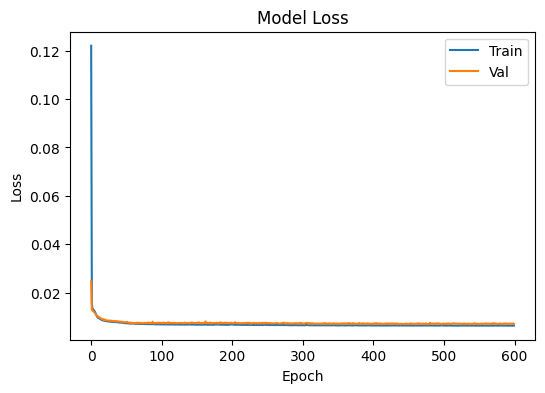

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(paper_history.history['loss'])
plt.plot(paper_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')
plt.show()

In [69]:
y_pred = paper_model.predict(X_test_scaled_df)
# Chekc the RMSE using keras.metrics.RootMeanSquaredError()
rmse = RMSE()
rmse.update_state(y_test,y_pred)
print('RMSE:',rmse.result().numpy())

4/4 [==============================] - 0s 2ms/step
RMSE: 0.1353596


In [70]:
paper_model.save('../content/CHF_paper_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Paper Results:**
![Author Results](https://github.com/yashfirkedata/DL-Critical-Heat-Flux-Prediction/blob/f346f46efc06641cf83f2a47b2303d4fca5f3fb5/images/basic_auth_models_results.png?raw=true)

*As you can see we pretty much got very close to the paper results! Its time to improve as much as possible from our end!*

# **Experiments**

## **Model 1**: Baseline

In [71]:
model1 = Sequential([
    layers.Dense(64, input_shape=(X_train_scaled_df.shape[-1],), activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])


In [72]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                448       
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
metrics = [keras.metrics.RootMeanSquaredError(name="rmse")]

model1.compile(optimizer=keras.optimizers.Adam(0.01),
              loss='mean_squared_error',
              metrics=metrics)

In [74]:
### Training the model
epochs = 200
batch_size = 32
history = model1.fit(X_train,y_train, validation_data = (X_val , y_val), epochs=epochs, batch_size=batch_size)

Epoch 1/200
44/44 [==============================] - 2s 11ms/step - loss: 19474.8047 - rmse: 139.5522 - val_loss: 0.0732 - val_rmse: 0.2706
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 0.3157 - rmse: 0.5619 - val_loss: 0.0411 - val_rmse: 0.2027
Epoch 3/200
44/44 [==============================] - 0s 6ms/step - loss: 0.0168 - rmse: 0.1296 - val_loss: 0.0131 - val_rmse: 0.1144
Epoch 4/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 6/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1145 - val_loss: 0.0125 - val_rmse: 0.1118
Epoch 7/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0125 - val_rmse: 0.1119
Epoch 8/200
44/44 [==============================] - 0s 7ms/st

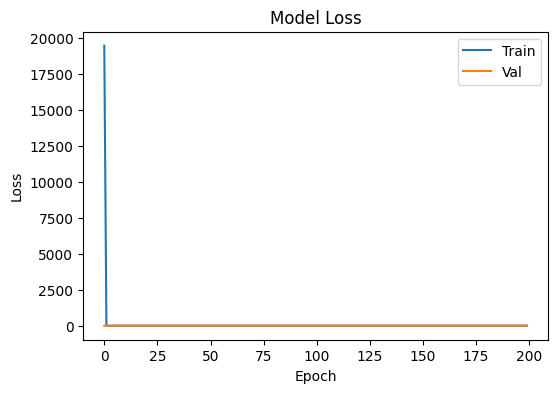

In [75]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')
plt.show()

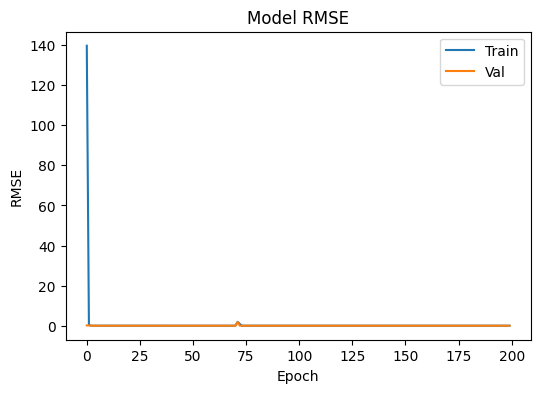

In [76]:
plt.figure(figsize=(6,4))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')
plt.show()

In [77]:
y_pred = model1.predict(X_test_scaled_df)
rmse = RMSE()
rmse.update_state(y_test,y_pred)
print('RMSE:',rmse.result().numpy())

4/4 [==============================] - 0s 3ms/step
RMSE: 0.14569087


In [78]:
model1.save('../content/baseline_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Lets try Hyperparameter Tuning**

In [79]:
!pip install keras-tuner

In [80]:
import keras_tuner as kt
from sklearn.model_selection import KFold

In [81]:
# model_builder function
def model_builder(hp):
    """Builds Model for Keras Tuner

    Args:
      hp: HyperParameters

    Returns:
      keras model: returns a compiled keras sequential model
    """
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[6]))

    # Tune the number of units in the Dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=5, step=1)):
        model.add(keras.layers.Dense(units=hp.Int(f'dense_units_{i}', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(keras.layers.Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [keras.metrics.RootMeanSquaredError(name="rmse")]

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanSquaredError(),
                  metrics=metrics)

    return model

In [82]:
from keras.callbacks import EarlyStopping, TensorBoard

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TensorBoard Callback
tensorboard = TensorBoard(log_dir='../model/tensorboard_logs')

In [83]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='../model/tuner_logs'
)

Reloading Tuner from ../model/tuner_logs/untitled_project/tuner0.json


In [84]:
# Create K-Fold Cross-Validation
K = 10  # Number of folds
kfold = KFold(n_splits=K, shuffle=True)

In [85]:
# Split the data for cross-validation
X_train_for_cv, X_testing, y_train_for_cv, y_testing = train_test_split(X, y, test_size=0.2, random_state=101, shuffle=True)

In [86]:
X_train_for_cv.shape, X_testing.shape, y_train_for_cv.shape, y_testing.shape

((1378, 6), (345, 6), (1378,), (345,))

In [87]:
# K-Fold Cross-Validation Loop
y.reset_index(drop=True, inplace=True) # I did this cuz indexes of X and y datasets werent aligned

for train_index, val_index in kfold.split(X_train_for_cv, y_train_for_cv):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = y[train_index], y[val_index]

    # Hyperparameter tuning with Keras Tuner
    tuner.search(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[tensorboard, early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Test the best model
test_loss, test_rmse = best_model.evaluate(X_testing, y_testing)

print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

11/11 [==============================] - 0s 4ms/step - loss: 79673.5938 - rmse: 282.2651
Test Loss: 79673.59375, Test RMSE: 282.2651062011719


In [89]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.values)

{'num_dense_layers': 1, 'dense_units_0': 96, 'learning_rate': 0.001, 'dense_units_1': 192, 'dense_units_2': 128, 'dense_units_3': 320, 'dense_units_4': 480}


In [88]:
best_model.save('../content/hyperparam_tunned_mod2.h5')
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 96)                672       
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
loadmodel = keras.models.load_model("../content/hyperparam_tunned_mod2.h5") # Further tunning this version of our model ....
loadmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 96)                672       
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **Final Model Retraining**

In [96]:
main_model = model = Sequential([
    layers.Dense(96, input_shape=(X_train.shape[1],), activation='relu'),
    layers.Dense(192, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(320, activation='relu'),
    layers.Dense(480, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [97]:
metrics = [keras.metrics.RootMeanSquaredError(name="rmse")]

main_model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='mean_squared_error',
              metrics=metrics)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard Callback
tensorboard = TensorBoard(log_dir='../model/tb_logs')

In [98]:
### Training the model
epochs = 300
batch_size = 32
history = main_model.fit(X_train_scaled_df,y_train,
                         validation_data = (X_val_scaled_df, y_val), epochs=epochs,
                         batch_size=batch_size, callbacks=[tensorboard,early_stopping])

Epoch 1/300
44/44 [==============================] - 2s 9ms/step - loss: 0.0272 - rmse: 0.1648 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 2/300
44/44 [==============================] - 0s 9ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 3/300
44/44 [==============================] - 0s 9ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 4/300
44/44 [==============================] - 0s 9ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 5/300
44/44 [==============================] - 0s 9ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 6/300
44/44 [==============================] - 0s 9ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 7/300
44/44 [==============================] - 0s 10ms/step - loss: 0.0134 - rmse: 0.1158 - val_loss: 0.0127 - val_rmse: 0.1129
Epoch 8/300
44/44 [==============================] - 0s 11ms/step - 

In [99]:
y_pred = main_model.predict(X_test_scaled_df)
rmse = RMSE()
rmse.update_state(y_test,y_pred)
print('RMSE:',rmse.result().numpy())

4/4 [==============================] - 0s 3ms/step
RMSE: 0.15221655


In [100]:
main_model.save('../content/Main_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
